<a href="https://colab.research.google.com/github/i-bukhari/Sentiment-Analysis-Lyrics/blob/main/LSTM_Doc2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the implementation of a sentiment analysis model on song lyrics using a combination of Long Short-Term Memory (LSTM) networks and Doc2Vec embeddings. It includes data preprocessing steps, model training, and evaluation to classify the lyrics as positive or negative based on valence scores.


# Data Preprocessing

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=53a25b37639fbb3b9477a324aa4bccda3b4fc38d68ee1df9c069140de87815ec
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
from langdetect import detect
import nltk
import torch

In [ ]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


##Removing Empty Lyrics and Non-english Lyrics

In [ ]:
def is_english(text):
    try:
        lang = detect(text)
        return lang == 'en'
    except:
        # If langdetect encounters an error (e.g., short text), return False
        return False
def lang(text):
    if is_english(text):
        return 1
    else:
        return

In [ ]:
original_df = pd.read_csv('muse_v3_with_lyrics_filled.csv') #upload csv manually!!
data = original_df[['lyric','valence_tags']]
data = data.dropna(subset=['lyric'])
data['lang'] = data['lyric'].apply(lang)
data = data.dropna(subset=['lang'])

In [ ]:
data = pd.read_csv('balanced.csv')

In [ ]:
data

,valence_tags,positivity,lyrics
0,3.000000,0,[Verse 1]. From the haunts of daily life. Wher...
1,3.858696,0,I was waiting for a mermaid to appear. Saying ...
2,7.616667,1,[Verse 1]. I waited for you winterlong. You se...
3,6.685000,1,The world is giving you the run around. It lea...
4,3.240000,0,[Verse 1]. You know what they say. That everyt...
...,...,...,...
16841,7.807083,1,If we received a warning call. Would we change...
16842,5.998475,1,[Verse 1]. I know so many. Places in the world...
16843,3.160000,0,I bring you death. And steal your breath. I am...
16844,2.530000,0,"Close your eyes, we're coming down. Close your..."


# Tokenization

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenization(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if remove_digits else r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    modified_text = text.replace('[','').replace(']', '').replace(':','').replace('!','').replace(',','').replace('.','')
    tokens = modified_text.lower().split()
    additional_words_to_remove = ["intro", "verse", "outro", "chorus","i","1","and","ill","2","3","4","5", "yeah","ya",
                                  "na","wan","uh","gon","ima","mm","uhhuh","bout","em","nigga","niggas","got","ta","lil",
                                  "ol","hey", "oooh","ooh","oh","youre","dont","im","youve","ive","theres","ill","yaka",
                                  "lalalala","la","da","di","yuh", "shawty","oohooh","shoorah","mmmmmm","ook","bidibambambambam",
                                  "shh","bro","ho","aint","cant","know","bambam", "shitll","tonka"]
    filtered_tokens = []
    for word in tokens:
        if word not in additional_words_to_remove and word not in string.punctuation:
            filtered_tokens.append(word)
    return filtered_tokens

data['tokens'] = data['lyrics'].apply(tokenization)

In [ ]:
data

,valence_tags,positivity,lyrics,tokens
0,3.000000,0,[Verse 1]. From the haunts of daily life. Wher...,"[from, the, haunts, of, daily, life, where, is..."
1,3.858696,0,I was waiting for a mermaid to appear. Saying ...,"[was, waiting, for, a, mermaid, to, appear, sa..."
2,7.616667,1,[Verse 1]. I waited for you winterlong. You se...,"[waited, for, you, winterlong, you, seem, to, ..."
3,6.685000,1,The world is giving you the run around. It lea...,"[the, world, is, giving, you, the, run, around..."
4,3.240000,0,[Verse 1]. You know what they say. That everyt...,"[you, what, they, say, that, everything, in, y..."
...,...,...,...,...
16841,7.807083,1,If we received a warning call. Would we change...,"[if, we, received, a, warning, call, would, we..."
16842,5.998475,1,[Verse 1]. I know so many. Places in the world...,"[so, many, places, in, the, world, follow, the..."
16843,3.160000,0,I bring you death. And steal your breath. I am...,"[bring, you, death, steal, your, breath, am, y..."
16844,2.530000,0,"Close your eyes, we're coming down. Close your...","[close, your, eyes, were, coming, down, close,..."


# Getting y
## If valence > 4.5: Positive else Negative

In [ ]:
def positivity(valence_score): #9-point scale
        if valence_score<=4.5:
            return 0
        else:
            return 1
data['positivity'] = data['valence_tags'].apply(positivity)

In [ ]:
data

,lyric,valence_tags,lang,tokens,positivity
0,[Intro: Eminem]\n'Cause sometimes you just fee...,4.550000,1.0,"[eminem, cause, sometimes, you, just, feel, ti...",1
1,[Verse]\nSaint Anger 'round my neck\nSaint Ang...,3.710000,1.0,"[saint, anger, round, my, neck, saint, anger, ...",0
2,[Intro: Rick Ross]\nLegendary\nRunners\nYou kn...,3.080000,1.0,"[rick, ross, legendary, runners, you, me, tril...",0
3,"[Intro]\nRoad runner, road runner\nGoing hundr...",6.555071,1.0,"[road, runner, road, runner, going, hundred, m...",1
4,[Intro]\nDie!\n\n[Verse]\nI don't need your fo...,3.771176,1.0,"[die, need, your, forgiveness, need, your, hat...",0
...,...,...,...,...,...
89978,[Verse 1]\nSay why\nI'm tearing stars apart\nS...,5.370000,1.0,"[say, why, tearing, stars, apart, show, how, w...",1
89983,"Hey, bride of mine\nI love you\nSo why'd you f...",5.370000,1.0,"[bride, of, mine, love, you, so, whyd, you, fi...",1
89984,The Snow Was Falling Through The Light\n( I di...,5.370000,1.0,"[the, snow, was, falling, through, the, light,...",1
89985,Desperate days\nWhen solutions are sold\nFor a...,5.370000,1.0,"[desperate, days, when, solutions, are, sold, ...",1


In [ ]:
# Check how many NaN values exist in the 'tokens' column
nan_count = data['tokens'].isna().sum()
print(f"Number of NaN values in 'tokens' column: {nan_count}")

# If there are NaN values and it makes sense to fill them with empty lists:
data['tokens'] = data['tokens'].apply(lambda x: x if isinstance(x, list) else [])


Number of NaN values in 'tokens' column: 0


In [ ]:
# Example application on DataFrame
# Ensure the 'tokens' column contains lists of words (tokens)
def join(tokens):
    sentence = ' '.join(tokens[:100])
    return sentence

data['clean_lyrics'] = data['tokens'].apply(join)
data

,valence_tags,positivity,lyrics,tokens,clean_lyrics
0,3.000000,0,[Verse 1]. From the haunts of daily life. Wher...,"[from, the, haunts, of, daily, life, where, is...",from the haunts of daily life where is waged t...
1,3.858696,0,I was waiting for a mermaid to appear. Saying ...,"[was, waiting, for, a, mermaid, to, appear, sa...",was waiting for a mermaid to appear saying com...
2,7.616667,1,[Verse 1]. I waited for you winterlong. You se...,"[waited, for, you, winterlong, you, seem, to, ...",waited for you winterlong you seem to be where...
3,6.685000,1,The world is giving you the run around. It lea...,"[the, world, is, giving, you, the, run, around...",the world is giving you the run around it leav...
4,3.240000,0,[Verse 1]. You know what they say. That everyt...,"[you, what, they, say, that, everything, in, y...",you what they say that everything in your life...
...,...,...,...,...,...
16841,7.807083,1,If we received a warning call. Would we change...,"[if, we, received, a, warning, call, would, we...",if we received a warning call would we change ...
16842,5.998475,1,[Verse 1]. I know so many. Places in the world...,"[so, many, places, in, the, world, follow, the...",so many places in the world follow the sun in ...
16843,3.160000,0,I bring you death. And steal your breath. I am...,"[bring, you, death, steal, your, breath, am, y...",bring you death steal your breath am your fien...
16844,2.530000,0,"Close your eyes, we're coming down. Close your...","[close, your, eyes, were, coming, down, close,...",close your eyes were coming down close your ey...


In [ ]:
#new_data = data.sample(n=2000, random_state=42)

# Visualization Data

In [ ]:
import matplotlib.pyplot as plt

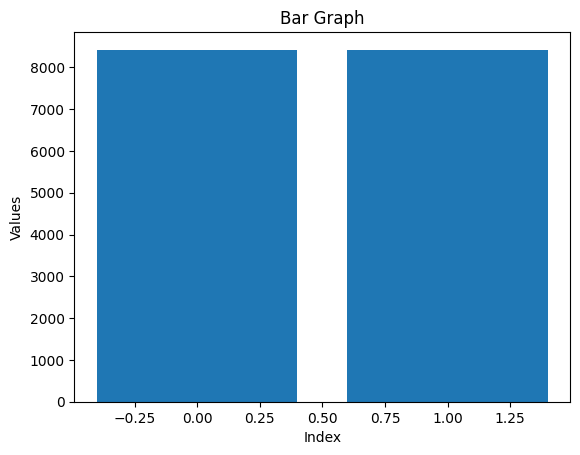

In [ ]:
cnt_pro = data['positivity'].value_counts()
plt.bar(cnt_pro.index, cnt_pro.values)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Bar Graph')
plt.show()

In [ ]:
###### BALANCE DATA #######

# Separate the classes based on 'positivity'
positive_df = data[data['positivity'] == 1]
negative_df = data[data['positivity'] == 0]
# Randomly sample from the majority class to match the size of the minority class
balanced_positive_df = positive_df.sample(n=len(negative_df), random_state=42)  # Ensuring reproducibility

# Concatenate with the minority class
balanced_df = pd.concat([balanced_positive_df, negative_df])
# Optionally shuffle the dataset
input_data = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Doc to Vec

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train, test = train_test_split(input_data, test_size=0.000001 , random_state=42)

In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [ ]:
input_data = data.copy()

In [ ]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['clean_lyrics']), tags=[r.positivity]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['clean_lyrics']), tags=[r.positivity]), axis=1)

In [ ]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each lyrics.
MAX_SEQUENCE_LENGTH = 100

In [ ]:
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, oov_token='UNK')

tokenizer.fit_on_texts(input_data['clean_lyrics'].values)
X = tokenizer.texts_to_sequences(input_data['clean_lyrics'].values)
# X = pad_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# Y = input_data['positivity'].values  # Ensure this is correct based on how positivity is stored
print('Found %s unique tokens.' % len(X))

Found 16846 unique tokens.


In [ ]:
# X = tokenizer.texts_to_sequences(new_data['clean_lyrics'].values)
X = tokenizer.texts_to_sequences(input_data['clean_lyrics'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (16846, 100)


In [ ]:
input_length = X.shape[1]
print(input_length)

100


In [ ]:
train_tagged.values

array([TaggedDocument(words=['lean', 'in', 'close', 'speak', 'to', 'me', 'low', 'tell', 'me', 'things', 'you', 'want', 'me', 'to', 'cause', 'want', 'to', 'be', 'the', 'one', 'you', 'need', 'to', 'lean', 'to', 'speak', 'to', 'me', 'low', 'regretful', 'its', 'the', 'time', 'of', 'year', 'for', 'letting', 'go', 'wasting', 'all', 'my', 'time', 'cause', 'you', 'just', 'tease', 'me', 'please', 'leave', 'me', 'alone', 'scared', 'of', 'the', 'feeling', 'of', 'you', 'coming', 'home', 'leaning', 'out', 'the', 'open', 'windows', 'looking', 'into', 'the', 'alley', 'below', 'rooftops', 'black', 'the', 'moons', 'hanging', 'low', 'the', 'telephone', 'wires', 'that', 'carry', 'the', 'sound', 'stretch', 'across', 'the', 'sky', 'under', 'the', 'ground', 'will', 'be', 'here', 'when', 'you', 'come', 'back', 'speak', 'to', 'me', 'low'], tags=[1]),
       TaggedDocument(words=['not', 'without', 'a', 'purpose', 'its', 'not', 'without', 'a', 'fight', 'three', 'tales', 'to', 'tell', 'you', 'so', 'please', 'sit

In [ ]:
# d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)

d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 16845/16845 [00:00<00:00, 1063219.33it/s]


In [ ]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 16845/16845 [00:00<00:00, 1757844.67it/s]


CPU times: user 2min 24s, sys: 658 ms, total: 2min 25s
Wall time: 2min 29s


In [ ]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [ ]:
# len(d2v_model.wv.vocab)
len(d2v_model.wv.key_to_index)


38752

In [ ]:
vocab_size = len(d2v_model.wv.key_to_index) + 1  # Vocabulary size + 1 for padding
vector_size = d2v_model.vector_size  # Dimensionality of the vectors



embedding_matrix = np.zeros((vocab_size, vector_size))

# Populate the embedding matrix with vectors from the model
for word, index in d2v_model.wv.key_to_index.items():
    # The index in the embedding matrix is offset by one due to padding token at index 0
    embedding_matrix[index] = d2v_model.wv[word]


Measuring distance between two vectors (related to cosine similarity)¶

In [ ]:
d2v_model.wv.most_similar(positive=['love'], topn=10)

[('bittersweet', 0.842785120010376),
 ('underlined', 0.7824863791465759),
 ('joy', 0.7812088131904602),
 ('clarify', 0.7423409223556519),
 ('desire', 0.7369310855865479),
 ('becauause', 0.7327426671981812),
 ('happiness', 0.7307034134864807),
 ('ylnen', 0.7259463667869568),
 ('darling', 0.719996452331543),
 ('forever', 0.713860034942627)]

In [ ]:
d2v_model.wv.most_similar(positive=['beautiful'], topn=10)

[('blue', 0.8709665536880493),
 ('magical', 0.8108376264572144),
 ('lovely', 0.7904194593429565),
 ('bright', 0.7881771922111511),
 ('wakens', 0.7794892191886902),
 ('starlight', 0.7701390981674194),
 ('histories', 0.7603241801261902),
 ('tragical', 0.7471455335617065),
 ('snowblind', 0.740058422088623),
 ('wonderful', 0.7397045493125916)]

In [ ]:
d2v_model.wv.most_similar(positive=['happy'], topn=10)

[('misunderstood', 0.7950345873832703),
 ('doo', 0.7174589037895203),
 ('rusting', 0.700584352016449),
 ('extinguished', 0.6992833614349365),
 ('chelsea', 0.6972525119781494),
 ('bree', 0.6938307881355286),
 ('vanities', 0.6893981099128723),
 ('sad', 0.6862866878509521),
 ('weatherwise', 0.6849592924118042),
 ('lennon', 0.6846234202384949)]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the PyTorch LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)  # Output 1 value for binary classification

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        dropped_out = self.dropout(hidden[-1])
        output = self.fc(dropped_out)
        return output  # Output raw logits for BCEWithLogitsLoss


# Initialize the model
vocab_size = len(d2v_model.wv.key_to_index) + 1
embedding_dim = d2v_model.vector_size
hidden_dim = 10
dropout_prob = 0.7

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, dropout_prob)

# Load pre-trained embeddings into the model's embedding layer
with torch.no_grad():
    model.embedding.weight.data.copy_(torch.tensor(embedding_matrix))

# Set up the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Specify loss function for binary classification with logits
criterion = nn.BCEWithLogitsLoss()


In [ ]:
torch.save(model, 'lstm_model.pth')

In [ ]:
Y = input_data['positivity'].values.reshape(-1, 1)  # Reshape for appropriate dimensionality
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape, "Y_test shape:", Y_test.shape)

X_train shape: (14322, 100) Y_train shape: (14322, 1)
X_test shape: (2528, 100) Y_test shape: (2528, 1)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

epoch_losses = []
epoch_accuracies = []

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True)

epoch_test_losses = []
epoch_test_accuracies = []

epochs = 30  # Define the number of epochs

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Before model(inputs)
        if inputs.max() >= vocab_size:
            raise ValueError("An input index is exceeding the vocabulary size.")

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = (outputs > 0).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    epoch_losses.append(train_loss / len(train_loader))
    epoch_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = (outputs > 0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        epoch_test_losses.append(test_loss / len(test_loader))
        epoch_test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {epoch_losses[-1]:.4f}, Train Accuracy: {epoch_accuracies[-1]:.4f}, Test Loss: {epoch_test_losses[-1]:.4f}, Test Accuracy: {epoch_test_accuracies[-1]:.4f}')


Epoch 1/30 - Train Loss: 0.6977, Train Accuracy: 0.4958, Test Loss: 0.6942, Test Accuracy: 0.5115
Epoch 2/30 - Train Loss: 0.6939, Train Accuracy: 0.5068, Test Loss: 0.6940, Test Accuracy: 0.4945
Epoch 3/30 - Train Loss: 0.6933, Train Accuracy: 0.5062, Test Loss: 0.6936, Test Accuracy: 0.4968
Epoch 4/30 - Train Loss: 0.6930, Train Accuracy: 0.5072, Test Loss: 0.6941, Test Accuracy: 0.4968
Epoch 5/30 - Train Loss: 0.6915, Train Accuracy: 0.5197, Test Loss: 0.6944, Test Accuracy: 0.4972
Epoch 6/30 - Train Loss: 0.6901, Train Accuracy: 0.5263, Test Loss: 0.6948, Test Accuracy: 0.5051
Epoch 7/30 - Train Loss: 0.6896, Train Accuracy: 0.5271, Test Loss: 0.6948, Test Accuracy: 0.5103
Epoch 8/30 - Train Loss: 0.6866, Train Accuracy: 0.5414, Test Loss: 0.6952, Test Accuracy: 0.5198
Epoch 9/30 - Train Loss: 0.6816, Train Accuracy: 0.5543, Test Loss: 0.6940, Test Accuracy: 0.5079
Epoch 10/30 - Train Loss: 0.6755, Train Accuracy: 0.5748, Test Loss: 0.6991, Test Accuracy: 0.5186
Epoch 11/30 - Train

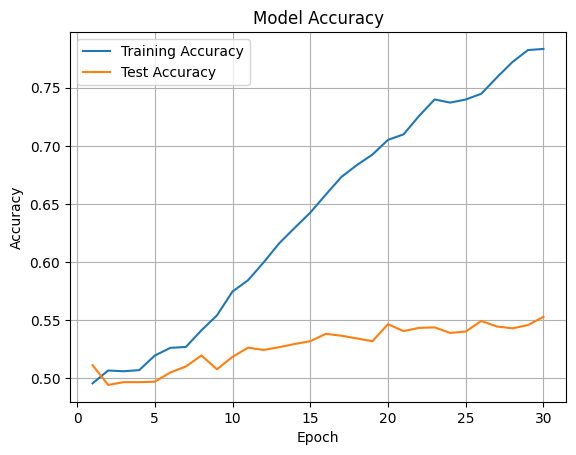

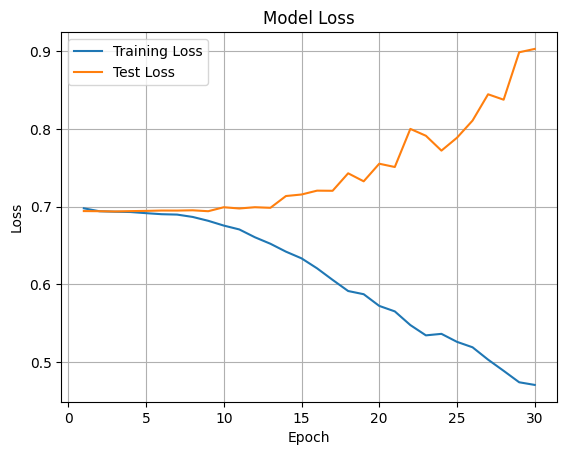

In [ ]:
# Plotting training and test accuracies
plt.figure()
plt.plot(range(1, epochs + 1), epoch_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), epoch_test_accuracies, label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plotting training and test losses
plt.figure()
plt.plot(range(1, epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), epoch_test_losses, label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = (outputs > 0).float()  # Using 0 as threshold for logits
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = running_loss / len(data_loader)
    return average_loss, accuracy

# Evaluate on training and test data
train_loss, train_acc = evaluate_model(model, train_loader, criterion)
test_loss, test_acc = evaluate_model(model, test_loader, criterion)

print('Train Accuracy: %.3f, Test Accuracy: %.4f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.4f' % (train_loss, test_loss))


Train Accuracy: 0.835, Test Accuracy: 0.5530
Train Loss: 0.391, Test Loss: 0.8963


In [ ]:
import torch
import numpy as np

def predict(model, data_loader):
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for inputs in data_loader:
            outputs = model(inputs)  # Get raw logits
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions.extend(outputs > 0)  # Using 0 as the threshold
            probabilities.extend(probs)

    # Convert lists of tensors to a single tensor
    predictions = torch.cat(predictions).numpy()
    probabilities = torch.cat(probabilities).numpy()

    return probabilities, predictions

test_loader = DataLoader(X_test_tensor, batch_size=32, shuffle=False)

# Using the model and test_loader to predict
yhat_probs, yhat_classes = predict(model, test_loader)

print("Probabilities:\n", yhat_probs)
print("Predicted Classes:\n", yhat_classes)


Probabilities:
 [0.7771525  0.83781904 0.7214005  ... 0.43772754 0.5596296  0.02267273]
Predicted Classes:
 [ True  True  True ... False  True False]


In [ ]:
rounded_labels = Y_test  # Assuming Y_test contains values 0 and 1 directly
print(rounded_labels)

print("Shape of Y_test:", Y_test.shape)
print("Sample labels from Y_test:", Y_test[:5])


[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
Shape of Y_test: (2528, 1)
Sample labels from Y_test: [[0]
 [1]
 [1]
 [0]
 [1]]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm


array([[632, 610],
       [520, 766]])

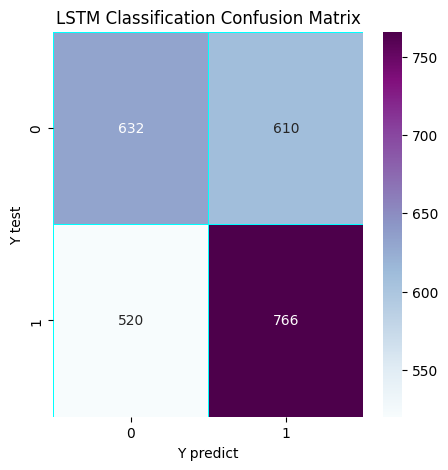

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 Score for binary classification
f1 = f1_score(rounded_labels, yhat_classes, average='binary')  #
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.58


#VALIDATION

In [ ]:
# Choose a validation size that is less than the number of test samples
validation_size = 150  # Make sure this number is less than num_test_samples

# Split the test set into new test set and validation set
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]

# Convert validation data to tensors
X_validate_tensor = torch.tensor(X_validate, dtype=torch.long)
Y_validate_tensor = torch.tensor(Y_validate, dtype=torch.float32)

# Create a DataLoader for the validation set
validate_loader = DataLoader(TensorDataset(X_validate_tensor, Y_validate_tensor), batch_size=32, shuffle=True)

# Evaluate on validation data
val_loss, val_acc = evaluate_model(model, validate_loader, criterion)

print('Validation Loss: %.3f, Validation Accuracy: %.4f' % (val_loss, val_acc))


Validation Loss: 0.825, Validation Accuracy: 0.5933


In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')

lyric = ['Oh It must be more than I need you More than I love you Be more than wishes on stars High above you If words could just hold you Tell me you feel me Oh, just to know you Tell me you see me I couldnt have said it (said it)You must have just read it (read it) In my eyes Darling, please Let it be more Be more Be more It must be more than I want you Be more than dancing in raindrops Falling to touch you, whoa, just to touch you, oh, just to touch you']
seq = tokenizer.texts_to_sequences(lyric)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

In [ ]:
# Convert the padded data to a PyTorch tensor
padded_tensor = torch.tensor(padded, dtype=torch.long)  # Ensure it matches the expected input datatype of the model

# Pass the tensor to the model to get logits
with torch.no_grad():  # No need to track gradients for inference
    logits = model(padded_tensor)

# Apply sigmoid to convert logits to probabilities
probabilities = torch.sigmoid(logits)

# Threshold probabilities at 0.5 to determine class labels
predicted_classes = (probabilities > 0.5).long()

# Assuming your classes are labeled as '0' and '1'
labels = ['0', '1']
predicted_labels = [labels[idx] for idx in predicted_classes.view(-1).numpy()]  # Flatten tensor and convert to numpy array

# Print the probabilities and predicted labels
print("Probabilities:", probabilities)
print("Predicted labels:", predicted_labels)

Probabilities: tensor([[0.6980]])
Predicted labels: ['1']
